# Data Cleaning with Pandas

*This notebook was adapted from Melanie Walsh's "Pandas Basics", [Part 3](https://melaniewalsh.github.io/Intro-Cultural-Analytics/03-Data-Analysis/03-Pandas-Basics-Part3.html#) and [Part 4](https://melaniewalsh.github.io/Intro-Cultural-Analytics/03-Data-Analysis/04-Pandas-Merge-Datasets.html).*

In this notebook, we will expand our knowledge of pandas by discussing the following aspects of data cleaning:

- Merging datasets
- More on the dataframe `index`
- Intro to accessor functions (e.g., working with strings, datetimes, etc.)
- Applying functions
- `map`, `reduce`, and `filter`
- The `.apply` method
- `pivot` and `melt`

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                 
import seaborn as sns

%config InlineBackend.figure_formats = ['svg']

# personal seaborn preferences ...
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

/var/folders/pv/kll1prqs39jc2wvhvd31dfmr0000gn/T/ipykernel_26319/1101864529.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Diversity in Film

**How many movies are actually dispropotionately featuring white men? What changes by genre, era, or box-office revenue? What circumstances generate more diversity?**

The dataset that we're working with in this lesson is taken from Hannah Andersen and Matt Daniels's *Pudding* essay, ["Film Dialogue from 2,000 screenplays, Broken Down by Gender and Age"](https://pudding.cool/2017/03/film-dialogue/). The dataset provides information about 2,000 films from 1925 to 2015, including characters’ names, genders, ages, how many words each character spoke in each film, the release year of each film, and how much money the film grossed. They included character gender information because they wanted to contribute data to a broader conversation about how "white men dominate movie roles."

Yet, transforming complex social constructs like gender into quantifiable data is tricky and historically fraught. They claim, in fact, that one of the [most frequently asked questions](https://medium.com/@matthew_daniels/faq-for-the-film-dialogue-by-gender-project-40078209f751) about the piece is about gender: E.g., *“How do you know the monster in Monsters Inc. is a boy!"* The short answer is that they don't. To determine character gender, they used actors' IMDB information, which they acknowledge is an imperfect approach: "Sometimes, women voice male characters. Bart Simpson, for example, is voiced by a woman. We’re aware that this means some of the data is wrong, AND we’re still fine with the methodology and approach."

> **What do you think about this approach to determining gender?** How does such a binary understanding of gender, gleaned from the IMDB pages of actors, influence our later results and conclusions? What do we gain by using such an approach, and what do we lose? How else might we have encoded or determined gender for the same data?

## Merging

When Andersen and Daniels published their essay, they used results from *two* related data tables. Before we proceed in this notebook, we'll merge the two.

In [3]:
df_metadata = pd.read_csv('/Users/ramyaamudapakula/Desktop/Sem1/Intro to Informatics/Projects/I501 labs and pair problems/lab_4/data/meta_data7.csv')
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   script_id   2000 non-null   int64  
 1   imdb_id     2000 non-null   object 
 2   title       2000 non-null   object 
 3   year        2000 non-null   int64  
 4   gross       1662 non-null   float64
 5   lines_data  2000 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 93.9+ KB


In [4]:
df_metadata.head(6)

,script_id,imdb_id,title,year,gross,lines_data
0,1534,tt1022603,(500) Days of Summer,2009,37.0,7435445256774780000000000000000000000000000000...
1,1512,tt0147800,10 Things I Hate About You,1999,65.0,1777752320274530000000000000000000000000000000...
2,1514,tt0417385,12 and Holding,2005,NaN,5461357777754220000000000000000000000000000000...
3,1517,tt2024544,12 Years a Slave,2013,60.0,4567334777777780000000000000000000000000000000...
4,1520,tt1542344,127 Hours,2010,20.0,453513352345766000000000000000
5,6537,tt0450385,1408,2007,91.0,37677777777777800000000000000000000000000000


The "lines_data" column apparently contains encoded information about when during the film each character speaks. Since we don't have the means (or need) to decode it, we'll drop the column altogether.

In [5]:
df_metadata.drop(columns='lines_data', inplace=True)

They published another CSV file called "character_list5.csv" that contains, among other things, the name, gender, and age of each character as well as the number of words the character speaks.

In [6]:
df_characters = pd.read_csv('/Users/ramyaamudapakula/Desktop/Sem1/Intro to Informatics/Projects/I501 labs and pair problems/lab_4/data/character_list5.csv')
df_characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23048 entries, 0 to 23047
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   script_id            23048 non-null  int64  
 1   imdb_character_name  23046 non-null  object 
 2   words                23048 non-null  int64  
 3   gender               23048 non-null  object 
 4   age                  18263 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 900.4+ KB


In [7]:
df_characters

,script_id,imdb_character_name,words,gender,age
0,280,betty,311,f,35.0
1,280,carolyn johnson,873,f,NaN
2,280,eleanor,138,f,NaN
3,280,francesca johns,2251,f,46.0
4,280,madge,190,f,46.0
...,...,...,...,...,...
23043,9254,lumiere,1063,m,56.0
23044,9254,maurice,1107,m,71.0
23045,9254,monsieur d'arqu,114,m,58.0
23046,9254,mrs. potts,564,f,66.0


As you can see, the characters DataFrame doesn't include the actual title of the movie in which the character appears or the movie's release year or box office gross. And `df_metadata` doesn't contain any information about the characters. We want that info all in one place.

There's one column that both datasets share in common: *script_id*. If two datasets share at least one column in common, we can merge them together based on this column. Using the [`pd.merge()` function](https://pandas.pydata.org/docs/user_guide/merging.html#brief-primer-on-merge-methods-relational-algebra), we link each corresponding row carying the same *script_id* value. As explained in the linked documentation, this could be **one-to-one**, **one-to-many**, or **many-to-many**. For example:

    Column values [1,2,3,4,5] merged with [6,7,8,9,10] will give 0 rows
    Column values [1,2,3,4,5] merged with [1,2,3,4,5] will give 5 rows
    Column values [1,1,1,1,1] merged with [1,1,1,1,1] will give 25 rows

In [8]:
df_a = pd.DataFrame({'a': [1, 2, 3, 4],
                     'letters_from_a': ['a', 'b', 'c', 'd']})

df_b = pd.DataFrame({'a': [2, 3, 4, 5, 6],
                     'letters_from_b': ['a', 'b', 'c', 'd', 'e']})

In [9]:
pd.merge(df_a, df_b, how='right')  # try the other `how` options

,a,letters_from_a,letters_from_b
0,2,b,a
1,3,c,b
2,4,d,c
3,5,NaN,d
4,6,NaN,e


In [10]:
df_films = pd.merge(df_characters, df_metadata, on='script_id')
df_films

,script_id,imdb_character_name,words,gender,age,imdb_id,title,year,gross
0,280,betty,311,f,35.0,tt0112579,The Bridges of Madison County,1995,142.0
1,280,carolyn johnson,873,f,NaN,tt0112579,The Bridges of Madison County,1995,142.0
2,280,eleanor,138,f,NaN,tt0112579,The Bridges of Madison County,1995,142.0
3,280,francesca johns,2251,f,46.0,tt0112579,The Bridges of Madison County,1995,142.0
4,280,madge,190,f,46.0,tt0112579,The Bridges of Madison County,1995,142.0
...,...,...,...,...,...,...,...,...,...
23043,9254,lumiere,1063,m,56.0,tt0101414,Beauty and the Beast,1991,452.0
23044,9254,maurice,1107,m,71.0,tt0101414,Beauty and the Beast,1991,452.0
23045,9254,monsieur d'arqu,114,m,58.0,tt0101414,Beauty and the Beast,1991,452.0
23046,9254,mrs. potts,564,f,66.0,tt0101414,Beauty and the Beast,1991,452.0


> What does each row represent now?

### data check
Running "data checks" or "gut checks" is just a good habit to get into, so I'll show an example here of gaining confidence that our merge went smoothly.

In [11]:
# validation check
df_characters.shape, df_metadata.shape

((23048, 5), (2000, 5))

In [12]:
df_films.shape

(23048, 9)

In [13]:
df_films.sample(10)

,script_id,imdb_character_name,words,gender,age,imdb_id,title,year,gross
16679,5820,alicia nash,1496,f,31.0,tt0268978,A Beautiful Mind,2001,262.0
20787,8019,father leary,587,m,NaN,tt2234003,Calvary,2014,3.0
18627,7104,emily,268,f,27.0,tt1369706,The Ward,2010,NaN
9201,2980,albuquerque,726,f,40.0,tt0073440,Nashville,1975,NaN
18391,6918,moses,2504,m,40.0,tt1528100,Exodus: Gods and Kings,2014,69.0
18756,7157,nikolai,526,m,30.0,tt1131734,Jennifer's Body,2009,18.0
6442,2265,debbie mcilvane,132,f,36.0,tt0120667,Fantastic Four,2005,210.0
5891,2126,bubba,174,m,NaN,tt0097165,Dead Poets Society,1989,210.0
18313,6867,puck beaverton,290,m,39.0,tt1791528,Inherent Vice,2014,8.0
9290,3009,lilli,821,f,75.0,tt0875034,Nine,2009,22.0


We can use `.duplicated` to build a Boolean series which logs duplicate rows. Rows that *are* duplicated can be counted using `.sum`.

In [14]:
df_films.duplicated().sum()

0

In [15]:
df_characters['words'].isna().sum() == df_films['words'].isna().sum()

True

In [16]:
# a bit of cleanup
df_films.rename(columns={'imdb_character_name': 'character', 
                         'year': 'release_year'}, inplace=True)

In [17]:
df_films.sample(5)

,script_id,character,words,gender,age,imdb_id,title,release_year,gross
9426,3033,samir nagheenan,1012,m,27.0,tt0151804,Office Space,1999,18.0
18592,7080,eve kendall,837,f,35.0,tt0053125,North by Northwest,1959,NaN
1037,878,jim,539,m,22.0,tt0099487,Edward Scissorhands,1990,116.0
8767,2857,dr. sherman,147,m,52.0,tt0822832,Marley & Me,2008,173.0
5393,1991,dalia,262,f,NaN,tt0118842,Chasing Amy,1997,22.0


## Minding the Index

**The safest way to create new columns is with the `df` on both sides of the `=` sign.** It *is* possible to create a pandas Series "*outside*" of the original DataFrame, and the index will line up with the DataFrame in question, but this is not a good habit to get into, as it's not uncommon for indices to morph throughout your manipulation work.

In [18]:
df_ = pd.DataFrame({'a': [1, 2, 3, 4, 5]})
df_

,a
0,1
1,2
2,3
3,4
4,5


In [19]:
series_ = pd.Series(index=[4, 1, 2], data=[5, 6, 7])

In [20]:
df_['series_'] = series_
df_

,a,series_
0,1,NaN
1,2,6.0
2,3,7.0
3,4,NaN
4,5,5.0


For example, let's start by looking at the total number of words and characters in each film.

In [21]:
df_title_words = df_films.groupby(['release_year']) \
                          .agg({'words': 'sum',
                                'character': 'nunique'}) \
                          .rename(columns = {"character": "n_characters"})
df_title_words

,words,n_characters
release_year,,
1929,8572,6
1931,11601,12
1932,67534,47
1933,21125,20
1934,24646,23
...,...,...
2011,944803,933
2012,654881,773
2013,637486,770


The `groupby` operation automatically assigns the "group" to the index because it is guaranteed to be unique.

### Resetting the Index

We could reset this if we like, as we typically will when we use `groupby`.

In [22]:
df_title_words.reset_index(inplace=True)
df_title_words

,release_year,words,n_characters
0,1929,8572,6
1,1931,11601,12
2,1932,67534,47
3,1933,21125,20
4,1934,24646,23
...,...,...,...
76,2011,944803,933
77,2012,654881,773
78,2013,637486,770
79,2014,707308,853


### Setting the Index

And we can reverse this by picking a column **with no duplicates** to be the index. <span style='color:darkred'>Note: pandas will not stop you from setting a column *with* duplicates as an index, so be careful.</span>

In [23]:
df_title_words.set_index('title')

KeyError: "None of ['title'] are in the columns"

### groupby and transform

Our data only contains the number of words a character spoke in a film, but supposing we want the proportion of words from the film, we'll need `groupby` and `transform`. This will be fine because the combination of `groupby` and `transform` will return a dataframe with the same index as our data frame.

In [24]:
# intermediate step ... this index should match that of `df_films`
title_word_totals = df_films.groupby(['title'])['words'].transform('sum')

In [25]:
df_films['proportion_of_dialogue'] = df_films['words'] / title_word_totals

In [26]:
df_films[['title', 'words', 'proportion_of_dialogue']].sort_values('title')

,title,words,proportion_of_dialogue
3700,(500) Days of Summer,134,0.007243
3709,(500) Days of Summer,600,0.032432
3708,(500) Days of Summer,8938,0.483135
3707,(500) Days of Summer,4080,0.220541
3706,(500) Days of Summer,112,0.006054
...,...,...,...
3552,xXx,1189,0.143512
3551,xXx,998,0.120459
3550,xXx,3714,0.448280
3548,xXx,318,0.038383


#### EXERCISE

What would be a good "gut check" to verify this operation?

## Accessor Objects

We've already seen many types of operations we can perform on virtually any kind of Series (or, DataFrame column), such as grouping, `transform`, adding/multiplying numbers, calculating aggregate values, etc. But, some operations which we have not discussed can only be applied to certain data types. For example, calculating a time interval makes sense given two dates, but it makes no sense given two random strings of characters.

[pandas Accessors](https://pandas.pydata.org/pandas-docs/stable/reference/series.html?highlight=accessor#accessors) are datatype-specific methods which can be applied to particular Series defined in pandas. Each one provides a vast range of operationality with their corresponding kinds of data. In this notebook, we'll give a couple examples of the accessors for [Categories](https://pandas.pydata.org/docs/user_guide/categorical.html), [Strings](https://pandas.pydata.org/docs/user_guide/text.html), and [Datetimes](https://pandas.pydata.org/docs/user_guide/timeseries.html).

### Category

To illustrate some of the nice aspects of the `.cat` accessor, let's take a look at the *age* column.

In [27]:
df_films['age'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.99])

count    18263.000000
mean        42.382960
std         59.718859
min          3.000000
10%         24.000000
25%         30.000000
50%         39.000000
75%         50.000000
99%         78.000000
max       2013.000000
Name: age, dtype: float64

Notice the maximum age ...

In [28]:
df_films[df_films['age'] > 100][['character', 'gender', 'age', 'title', 'release_year']]

,character,gender,age,title,release_year
4024,harold carnes,m,2000.0,American Psycho,2000
5254,margaret sulliv,f,2009.0,Case 39,2009
5370,bernie callo,m,2005.0,Chaos,2005
5950,realtor,m,2006.0,The Departed,2006
6899,thorpey,m,2000.0,Get Carter,2000
7787,bull,m,2007.0,Into the Wild,2007
7968,silent bob's mo,f,2001.0,Jay and Silent Bob Strike Back,2001
9233,monty malik,m,1999.0,Never Been Kissed,1999
9617,nessie,f,1993.0,The Piano,1993
9819,reporter,m,1980.0,Raging Bull,1980


Before we can even continue, we notice the age looks to be confused with the year of the movie release for several instances. There are a few ways to rectify this, but for now, we'll set incorrect age values to be missing. *What are some other ways we could manage this issue?*

In [29]:
# something a bit more explicit than an arbitrary "max" year
mask = df_films['age'] == df_films['release_year']

In [30]:
# pandas NaN is actually a np.nan object
df_films.loc[mask, 'age'] = np.nan

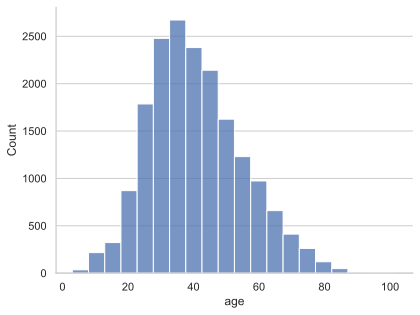

In [31]:
g = sns.histplot(df_films['age'], bins=20)
g.grid(False, axis='x');

Our goal here is to create categories based on the *age* of each character, i.e., we want "age groups". Since we should **never choose arbitrary breaks in data**, we'll use the [NIH age groups](https://www.nih.gov/nih-style-guide/age) to divide our data, and we'll translate the groups into our DataFrame using `cut`, as we've seen before.

In [32]:
df_films['age_group'] = pd.cut(df_films['age'], 
                               bins=[-1, 1, 12, 17, 65, 999],
                               labels=['Infant', 'Child', 'Adolescent', 'Adult', 'Older Adult'])

In [33]:
# data check
df_films.groupby('age_group')['age'].agg(['min', 'max'])

/var/folders/pv/kll1prqs39jc2wvhvd31dfmr0000gn/T/ipykernel_26319/3540895954.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_films.groupby('age_group')['age'].agg(['min', 'max'])


,min,max
age_group,,
Infant,NaN,NaN
Child,3.0,12.0
Adolescent,13.0,17.0
Adult,18.0,65.0
Older Adult,66.0,102.0


In [34]:
df_films['age_group']

0              Adult
1                NaN
2                NaN
3              Adult
4              Adult
            ...     
23043          Adult
23044    Older Adult
23045          Adult
23046    Older Adult
23047          Adult
Name: age_group, Length: 23048, dtype: category
Categories (5, object): ['Infant' < 'Child' < 'Adolescent' < 'Adult' < 'Older Adult']

In [35]:
df_films['age_group'].cat.ordered

True

Notice, categories can be *ordered* as the are here, and we can also use `cat.codes()` to convert them to numerical values (and back).

In [36]:
#  notice the use of `.cat` here
pd.concat((df_films['age_group'], 
           df_films['age_group'].cat.codes), axis=1).drop_duplicates()

,age_group,0
0,Adult,3
1,NaN,-1
46,Adolescent,2
80,Older Adult,4
116,Child,1


In [37]:
df_films['age_group'].cat.categories

Index(['Infant', 'Child', 'Adolescent', 'Adult', 'Older Adult'], dtype='object')

Since the categories are ordered, we should see them show up "in order" in Seaborn plots, too. For example, suppose we are interested in looking at how the age group distribution in movies changes over the years.

In [38]:
df_films.head()

,script_id,character,words,gender,age,imdb_id,title,release_year,gross,proportion_of_dialogue,age_group
0,280,betty,311,f,35.0,tt0112579,The Bridges of Madison County,1995,142.0,0.048639,Adult
1,280,carolyn johnson,873,f,NaN,tt0112579,The Bridges of Madison County,1995,142.0,0.136534,NaN
2,280,eleanor,138,f,NaN,tt0112579,The Bridges of Madison County,1995,142.0,0.021583,NaN
3,280,francesca johns,2251,f,46.0,tt0112579,The Bridges of Madison County,1995,142.0,0.352049,Adult
4,280,madge,190,f,46.0,tt0112579,The Bridges of Madison County,1995,142.0,0.029715,Adult


In [39]:
df_films_by_year = df_films.groupby(['release_year', 'age_group'], observed=True)['character'].agg([('num_characters', 'count')]).reset_index()
df_films_by_year.head()

,release_year,age_group,num_characters
0,1929,Adult,6
1,1931,Adult,11
2,1931,Older Adult,1
3,1932,Adult,43
4,1932,Older Adult,4


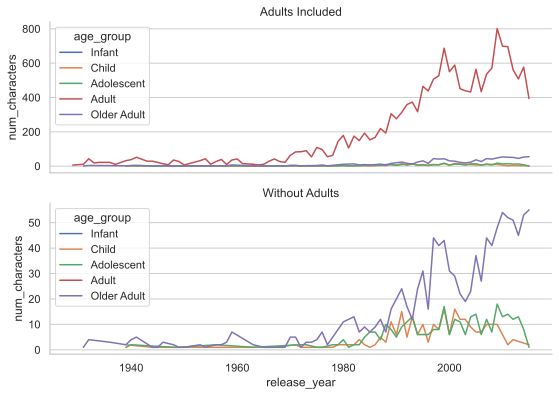

In [40]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(9, 6))

# adults included
sns.lineplot(df_films_by_year, x='release_year', y='num_characters', hue='age_group', ax=axes[0])
axes[0].grid(False, axis='x')
axes[0].set_title("Adults Included")

# adults excluded
mask = df_films_by_year['age_group'] != 'Adult'
sns.lineplot(df_films_by_year[mask], x='release_year', y='num_characters', hue='age_group', ax=axes[1])
axes[1].grid(False, axis='x')
axes[1].set_title("Without Adults");

### EXERCISE

What are some issues with these plots? Try to come up with at least one issue with the above data visualizations, and edit (or, rewrite) the code to build a different view of the data.

### String

pandas also provides accessors objects for strings. Built from the Python string methods, the pandas string methods will transform each string value in a column, and run the operator called after `.str`.

| **Pandas String Method** | **Explanation**                                                                                   |
|:-------------:|:---------------------------------------------------------------------------------------------------:|
| df['column_name']`.str.lower()`         | makes the string in each row lowercase                                                                                |
| df['column_name']`.str.upper()`         | makes the string in each row uppercase                                                |
| df['column_name']`.str.title()`         | makes the string in each row titlecase                                                |
| df['column_name']`.str.replace('old string', 'new string')`      | replaces `old string` with `new string` for each row |
| df['column_name']`.str.contains('some string')`      | tests whether string in each row contains "some string" |
| df['column_name']`.str.split('delim')`          | returns a list of substrings separated by the given delimiter |
| df['column_name']`.str.join(list)`         | opposite of split(), joins the elements in the given list together using the string                                                                        |
                                                            

For example, to transform every character's name in the "character" column from all lowercase to title case (i.e., capitalize the first letter of each "word"), we can use `.str.title()` .

In [41]:
df_films['character'] = df_films['character'].str.title()
df_films['character'].head()

0              Betty
1    Carolyn Johnson
2            Eleanor
3    Francesca Johns
4              Madge
Name: character, dtype: object

If we want to replace the gender column's single letter abbreviation to "male" / "female", we could use the `.str.replace()` method. 

In [42]:
df_films['gender'] = df_films['gender'].str.replace('m', 'male')

In [43]:
df_films['gender'] = df_films['gender'].str.replace('f', 'female')

In [44]:
df_films.sample(5)

,script_id,character,words,gender,age,imdb_id,title,release_year,gross,proportion_of_dialogue,age_group
19268,7362,Bernie,1090,female,NaN,tt2837296,Second Coming,2014,NaN,0.158869,NaN
3529,1483,Uncle Henry,148,male,70.0,tt0032138,The Wizard of Oz,1939,839.0,0.015766,Older Adult
1271,937,Royce,901,male,37.0,tt0119173,G.I. Jane,1997,91.0,0.107633,Adult
4064,1650,Helen,1204,female,30.0,tt1174732,An Education,2009,14.0,0.058384,Adult
3510,1482,Carter,119,male,NaN,tt0090329,Witness,1985,160.0,0.020370,NaN


We can use the `.str.contains()` to search for particular words or phrases in a column, such as "Star Wars."

In [45]:
df_films[df_films['title'].str.contains('Star Wars')].sample(5)

,script_id,character,words,gender,age,imdb_id,title,release_year,gross,proportion_of_dialogue,age_group
3018,1359,Ben 'Obi-Wan' K,462,male,69.0,tt0086190,Star Wars: Episode VI - Return of the Jedi,1983,853.0,0.090766,Older Adult
10600,3427,Padme,1561,female,24.0,tt0121766,Star Wars: Episode III - Revenge of the Sith,2005,515.0,0.112326,Adult
10613,3433,Princess Leia,1025,female,24.0,tt0080684,Star Wars: Episode V - The Empire Strikes Back,1980,937.0,0.111015,Adult
3027,1360,Anakin Skywalke,2061,male,21.0,tt0121765,Star Wars: Episode II - Attack of the Clones,2002,465.0,0.274251,Adult
10627,3437,Queen Amidala,656,female,18.0,tt0120915,Star Wars: Episode I - The Phantom Menace,1999,813.0,0.061091,Adult


### Datetime

The pandas `datetime` object contains several different [methods](https://pandas.pydata.org/pandas-docs/stable/reference/series.html?highlight=accessor#datetimelike-properties) which can be used to shed light on date/datetime data, but the benefit of using them is most apparent when we have dates/times down to the day or even hour. In `df_films`, we only have year aggregation, so it would be difficult to show the benefits of the datetime accessor.

We will discuss datetime Series in-depth when we cover Time Series data in a later lesson, but for now we'll introduce them using a related data set found on [Box Office Mojo](https://www.boxofficemojo.com), namely the 2023 [top 200 box office films](https://www.boxofficemojo.com/year/2023).

**A Quick Note on Web Scraping**

Web scraping is a method by which we collect data from websites online using code. There are several Python packages built specifically for web scraping (e.g., [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/), and [Scrapy](https://scrapy.org/)), but this method of collecting data is usually less effective than other alternatives we'll discuss in future lessons. That said, when web scraping actually is more effective, usually the website uses HTML tables, which pandas can parse using `read_html`.

*Note: you may need to install `lxml` (in this environment; and restart your kernel) to run the next cell.*

In [80]:
# see the documentation on `read_html`
df_mojo = pd.read_html('https://www.boxofficemojo.com/year/2023', match='Rank')[0]
df_mojo.head()

,Rank,Release,Genre,Budget,Running Time,Gross,Theaters,Total Gross,Release Date,Distributor,Estimated
0,1,Barbie,-,-,-,"$636,225,983",4337,"$636,238,421",Jul 21,Warner Bros.,False
1,2,The Super Mario Bros. Movie,-,-,-,"$574,934,330",4371,"$574,934,330",Apr 5,Universal Pictures,False
2,3,Spider-Man: Across the Spider-Verse,-,-,-,"$381,311,319",4332,"$381,311,319",Jun 2,Columbia Pictures,False
3,4,Guardians of the Galaxy Vol. 3,-,-,-,"$358,995,815",4450,"$358,995,815",May 5,Walt Disney Studios Motion Pictures,False
4,5,Oppenheimer,-,-,-,"$326,101,370",3761,"$328,770,130",Jul 21,Universal Pictures,False


In [81]:
# these are some columns we don't need
df_mojo.drop(columns=['Genre', 'Budget', 'Running Time', 'Estimated'], inplace=True)

In [82]:
# clean up column names using a dictionary comprehension
df_mojo.rename(columns={c:c.lower().replace(" ", "_") for c in df_mojo.columns},
               inplace=True)

In [83]:
df_mojo.columns

Index(['rank', 'release', 'gross', 'theaters', 'total_gross', 'release_date',
       'distributor'],
      dtype='object')

In [84]:
df_mojo['release_date']

0      Jul 21
1       Apr 5
2       Jun 2
3       May 5
4      Jul 21
        ...  
195    May 12
196    Dec 23
197     Apr 7
198    Mar 17
199     Jun 2
Name: release_date, Length: 200, dtype: object

It's a bit rare to see a date column without a year. Since we know the year for all of these is 2023 (this comes from the 2023 box office), we can tack that on to the release date using the `+` operator. Then, `pd.to_datetime` is the [preferred method](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) to parse and convert a date-looking string into a datetime object.

In [85]:
df_mojo['release_date'] = pd.to_datetime(df_mojo['release_date'] + " 2023")

In [86]:
df_mojo['release_date']

0     2023-07-21
1     2023-04-05
2     2023-06-02
3     2023-05-05
4     2023-07-21
         ...    
195   2023-05-12
196   2023-12-23
197   2023-04-07
198   2023-03-17
199   2023-06-02
Name: release_date, Length: 200, dtype: datetime64[ns]

Let's make a column for the month of the release, and another one for the quarter.

In [87]:
df_mojo['release_month'] = df_mojo['release_date'].dt.month
df_mojo['release_quarter'] = df_mojo['release_date'].dt.quarter
df_mojo['release_month']
df_mojo['release_quarter']

0      3
1      2
2      2
3      2
4      3
      ..
195    2
196    4
197    2
198    1
199    2
Name: release_quarter, Length: 200, dtype: int32

## Applying Functions

### Lambda Functions

Before we go on, let's take a quick aside from pandas to introduce [anonymous functions](https://realpython.com/python-lambda/#anonymous-functions), or in Python "lambda functions". As we've seen before, we can define "named" functions `myfunc` in Python using the standard `def` and `return` syntax, and then call them with parentheses `myfunc()`. But, it's not always the case that you need a function that can be called, rather you want to use the power of a function within another method. For this, we use a lambda function, which is set to take in some set of variables, and return a result.

    lambda var1: f(var1)
    lambda var1, var2: f(var1, var2)

For example, suppose we are given a list of full names, and we want to sort them based on the last name.

In [46]:
names = ["Jean-Luc Picard", "Beverly Crusher", "Deanna Troi", "William Riker", "Geordi LaForge"]
sorted(names)

['Beverly Crusher',
 'Deanna Troi',
 'Geordi LaForge',
 'Jean-Luc Picard',
 'William Riker']

In [47]:
sorted(names, key=lambda n: n.split(" ")[1])

['Beverly Crusher',
 'Geordi LaForge',
 'Jean-Luc Picard',
 'William Riker',
 'Deanna Troi']

### Map, Filter, and Reduce

Another use for lambda functions (outside of pandas, that is) involves using `map`, `filter`, or `reduce` functions.

In [48]:
from functools import reduce

The `map` function "applies" a given function to each element of an iterable. It returns a [*generator*](https://realpython.com/introduction-to-python-generators/#understanding-generators) object, which as we've seen before needs to be iterated through. **Think of a generator like a slide deck**, where the thing itself doesn't reveal any of its elements until you are ready for the "next slide". Also like a slide deck, when it's over, it's over.

In [49]:
first_names = map(lambda n: n.split(" ")[0], names)

In [50]:
# run this cell until you can't anymore ...
next(first_names)

'Jean-Luc'

In [51]:
# after running the above cell, we need to redefine the generator
first_names = map(lambda n: n.split(" ")[0], names)
[i for i in first_names]

['Jean-Luc', 'Beverly', 'Deanna', 'William', 'Geordi']

In [52]:
# after running the above cell, try running this cell
# [i for i in first_names]

`filter` is similar to `map` in that it returns a generator, but its purpose is to *filter* the elements of the iterable based on some condition.

In [53]:
hyphenated_names = filter(lambda n: "-" in n, names)
[i for i in hyphenated_names]

['Jean-Luc Picard']

Lastly, `reduce` is meant to combine elements into one. It uses a function which (typically) takes in two variables. This function is applied to the first two elements of the iterable, and then its applied to the resulting value and the next element of the iterable, and so on.

    reduce(lambda a, b: f(a, b), [e1, e2, e3, e4, e5])
    
    step 1: f(e1, e2) ---> R1
    step 2: f(R1, e3) ---> R2
    step 3: f(R2, e4) ---> R3
    step 4: f(R3, e5) ---> final result

For example, we can use it to compute an average of a set of numbers. 

In [54]:
list_of_numbers = [5, 4, 2, 7, 19]

In [55]:
reduce(lambda a, b: a + b, list_of_numbers) / len(list_of_numbers)

7.4

In [56]:
np.mean(list_of_numbers)

7.4

Or, further, an average of averages, if we combine `map` with `reduce`.

In [57]:
list_of_samples = [[1, 4, 3], [5, 4, 2], [9, 2, 1]]

In [58]:
list_of_averages = map(np.mean, list_of_samples)

In [59]:
# sum of three values over 3
reduce(lambda a, b: a + b, list_of_averages) / len(list_of_samples)

3.444444444444444

In [60]:
# this list comprehension will flatten a list of lists
l = [e for sublist in list_of_samples for e in sublist]
l

[1, 4, 3, 5, 4, 2, 9, 2, 1]

In [61]:
# the average of averages is the average of the full set
np.mean(l)

3.4444444444444446

Note, ["Map-Reduce"](https://en.wikipedia.org/wiki/MapReduce) is actually a process by which (a cluster of) computers can manage processing on huge (petabyte-scale) datasets, and it uses an application of exactly the same idea above, just on a much larger scale.

### Apply Functions

Using the same sort of thinking we've illustrated above, we can *apply* functions (lambda or otherwise) across all values in a column (or, any number of columns) using `.apply`. For instance, in `df_films`, we notice that character names are sometimes single names (like "Peter"), and other times, they contain last names or sometimes even middle names. Let's make a column that counts the number of "sub-names" in a characters name.

In [62]:
df_films[df_films['character'].isna()]

,script_id,character,words,gender,age,imdb_id,title,release_year,gross,proportion_of_dialogue,age_group
4656,1807,NaN,146,female,NaN,tt0120603,Beloved,1998,42.0,0.005162,NaN
19448,7445,NaN,520,female,NaN,tt0093223,House of Games,1987,5.0,0.165184,NaN


In [63]:
def subnames(name):
    '''
    Using the idea that multiple subnames can only occur with a space, we 
    count the spaces, and add one to get the number of subnames.
    '''
    # what if the character name is missing?
    if pd.isna(name):
        n_subnames = 0
    else:
        n_subnames = name.count(" ") + 1
        
    return n_subnames

In [64]:
df_films['n_character_subnames'] = df_films['character'].apply(subnames)

In [65]:
df_films['n_character_subnames'].unique()

array([1, 2, 3, 4, 7, 5, 8, 0, 6, 9])

Greater than four subnames seems a bit odd. To investigate this particular number of subnames (as a start), we can also use `.apply` on the column axis. In this way, the function is taking in a row (i.e., a pandas Series).

In [66]:
def messy_name(r):
    # this number 
    if r['n_character_subnames'] > 4:
        subnames = r['character'].split(" ")
    else:
        subnames = "not messy"
    return subnames

In [67]:
df_films['messy_name'] = df_films.apply(messy_name, axis=1)

In [68]:
cols = ['character', 'n_character_subnames', 'messy_name']
df_films[df_films['messy_name'] != "not messy"][cols]

,character,n_character_subnames,messy_name
1449,Mr. Borgin,7,"[Mr., Borgin, , , , , ]"
2623,Riff Raff - A H,5,"[Riff, Raff, -, A, H]"
2959,Gregory (,8,"[Gregory, , , , , , , (]"
4723,Sam - Man In Di,5,"[Sam, -, Man, In, Di]"
5026,Ward Abbott,6,"[Ward, Abbott, , , , ]"
6088,Clinic Girl,6,"[Clinic, Girl, , , , ]"
7077,Clerk (U,9,"[Clerk, , , , , , , , (U]"
7303,Watts (Ar,8,"[Watts, , , , , , , (Ar]"
8089,Fidget (C,8,"[Fidget, , , , , , , (C]"
8833,Bert (Cre,8,"[Bert, , , , , , , (Cre]"


## Melt and Pivot

When we extract data from [The World Bank Databases](https://data.worldbank.org/), we need to be careful to set the layout so that our data is in the orientation we want. In most cases, we want a "long" data frame where columns are variables, rows are observations, and values correspond to the two. Let's take a look at a small set of data extracted from the [Food Prices for Nutrition](https://databank.worldbank.org/source/food-prices-for-nutrition) database, where the orientation isn't quite right.

In [69]:
df_foods = pd.read_csv("/Users/ramyaamudapakula/Desktop/Sem1/Intro to Informatics/Projects/I501 labs and pair problems/lab_4/data/cost_of_food.csv").dropna()
df_foods.head()

,Classification Name,Classification Code,Country Name,Country Code,Series Name,Series Code,2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021]
0,Food Prices for Nutrition 1.0,FPN 1.0,United States,USA,Cost of a healthy diet,CoHD,3.225000e+00,3.240000e+00,3.268000e+00,3.383000e+00,..
1,Food Prices for Nutrition 1.0,FPN 1.0,United States,USA,Population,Pop,3.251221e+08,3.268382e+08,3.283300e+08,3.294841e+08,..
2,Food Prices for Nutrition 1.0,FPN 1.0,United States,USA,Millions of people who cannot afford a healthy...,CoHD_unafford_n,6.500000e+00,5.700000e+00,4.900000e+00,4.900000e+00,..
3,Food Prices for Nutrition 1.0,FPN 1.0,World,WLD,Cost of a healthy diet,CoHD,3.314000e+00,3.350000e+00,3.425000e+00,3.537000e+00,..
4,Food Prices for Nutrition 1.0,FPN 1.0,World,WLD,Population,Pop,7.208181e+09,7.249963e+09,7.327597e+09,7.401935e+09,..


In [70]:
# clean up columns names
def clean_col_name(col):
    if 'YR' in col:
        end = col.find('[') - 1
        return col[:end]
    else:
        return col.lower().replace(" ", "_")
        
df_foods.rename(columns={c: clean_col_name(c) for c in df_foods.columns},
                inplace=True)

In [71]:
# we want country, series, and year for Food Prices for Nutrition (FPN) 2.0
df_foods = df_foods[df_foods['classification_code'] == "FPN 2.0"] \
                .drop(columns=['classification_name', 
                               'classification_code',
                               'country_code', 'series_code'])

In [81]:
df_foods

,country_name,series_name,2017,2018,2019,2020,2021
12,United States,Cost of a healthy diet,3.225000e+00,3.240000e+00,3.268000e+00,3.383000e+00,3.5
13,United States,Population,3.251221e+08,3.268382e+08,3.283300e+08,3.315011e+08,331893745
14,United States,Millions of people who cannot afford a healthy...,6.500000e+00,5.700000e+00,4.900000e+00,4.100000e+00,4
15,World,Cost of a healthy diet,3.295000e+00,3.355000e+00,3.431000e+00,3.511000e+00,3.662
16,World,Population,7.262444e+09,7.304447e+09,7.381667e+09,7.455672e+09,7519145737
17,World,Millions of people who cannot afford a healthy...,3.124900e+03,3.019100e+03,3.005500e+03,3.191900e+03,3139.5


### Melt

Notice that the *series_name* column actually contains what we want to be *column* names. Also, note that each year listed here should really be a *row* value. This data frame is an example of a "wide" data frame, which we want to be reoriented as a "long" data frame. To do this, we use `melt` to create another data frame which is still technically wide, but at least brings us closer to what we want. Here, the columns that we are "melting" are the years.

In [72]:
df_foods_melted = df_foods.melt(id_vars=['country_name', 'series_name'],
                                value_vars=[c for c in df_foods if 'name' not in c],  # <-- melt
                                value_name="series_value",
                                var_name='year')  

In [73]:
df_foods_melted

,country_name,series_name,year,series_value
0,United States,Cost of a healthy diet,2017,3.225
1,United States,Population,2017,325122128.0
2,United States,Millions of people who cannot afford a healthy...,2017,6.5
3,World,Cost of a healthy diet,2017,3.295
4,World,Population,2017,7262444211.0
5,World,Millions of people who cannot afford a healthy...,2017,3124.9
6,United States,Cost of a healthy diet,2018,3.24
7,United States,Population,2018,326838199.0
8,United States,Millions of people who cannot afford a healthy...,2018,5.7
9,World,Cost of a healthy diet,2018,3.355


### Pivot

Now, we will create a proper "long" data frame by **pivoting** the *series_name* column as columns. We do this using `pd.pivot`. This is sort of the *reverse* of `melt`.

In [74]:
df_foods_pivoted = pd.pivot(df_foods_melted, 
                            index=['country_name', 'year'],   # a unique identifier for each row
                            columns=['series_name'],          # the column containing column names
                            values='series_value')            # the values of interest

df_foods_pivoted.reset_index(inplace=True) 
df_foods_pivoted.rename_axis(None, axis=1, inplace=True)      # remove the named index

In [75]:
df_foods_melted.sample(5)

,country_name,series_name,year,series_value
13,United States,Population,2019,328329953.0
23,World,Millions of people who cannot afford a healthy...,2020,3191.9
21,World,Cost of a healthy diet,2020,3.511
2,United States,Millions of people who cannot afford a healthy...,2017,6.5
24,United States,Cost of a healthy diet,2021,3.5


In [76]:
df_foods_pivoted.sample(5)

,country_name,year,Cost of a healthy diet,Millions of people who cannot afford a healthy diet,Population
1,United States,2018,3.24,5.7,326838199.0
2,United States,2019,3.268,4.9,328329953.0
6,World,2018,3.355,3019.1,7304446818.0
3,United States,2020,3.383,4.1,331501080.0
5,World,2017,3.295,3124.9,7262444211.0


## EXERCISES

## Part 1

Each one of these movies is a top box office movie, which we can temporarily call a "blockbuster". Let's investigate the (financial) performance of these movies based on how long it's been since the last blockbuster was released. (So, we're looking at the time between each row as the "time since last blockbuster"...)

In this exercise, make a new column which represents the time since the last blockbuster, and plot the *total_gross* (as a number) against that value.

*Hint: Take a look at the pandas [`shift`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html) method.*

In [77]:
# Sorting the DataFrame(df_films) by release_year to ensure proper order
df_films = df_films.sort_values(by='release_year')

# Identifying blockbuster movies(using 200 as a threshold value)
blockbuster_movies = df_films['gross'] > 200

# Creating a new column 'time_since_last_blockbuster' using the shift method
df_films['time_since_last_blockbuster'] = df_films['release_year'] - df_films.loc[blockbuster_movies, 'release_year'].shift(1)

# Plotting 'total_gross' against 'time_since_last_blockbuster'
plt.plot(df_films['release_year'], df_films['gross'], marker='o', linestyle='-')
plt.xlabel('Time Since Last Blockbuster (years)')
plt.ylabel('Total Gross')
plt.title('Financial Performance vs Time Since Last Blockbuster')
plt.show()

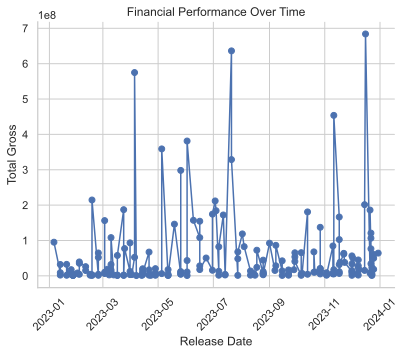

In [88]:
### Wasn't sure if we were supposed to use the df_films dataset or df_mojo :/
# Converting 'total_gross' column to numeric
df_mojo['total_gross'] = df_mojo['total_gross'].replace('[\$,]', '', regex=True).astype(float)

# Sorting the DataFrame by release_date to ensure proper order
df_mojo = df_mojo.sort_values(by='release_date')

# Creating a new column 'time_since_last_blockbuster' using the shift method for all movies
df_mojo['time_since_last_blockbuster'] = (df_mojo['release_date'] - df_mojo['release_date'].shift(1))

# Plotting total_gross against time_since_last_blockbuster
plt.plot(df_mojo['release_date'], df_mojo['total_gross'], marker='o', linestyle='-')
plt.xlabel('Release Date')
plt.ylabel('Total Gross')
plt.title('Financial Performance Over Time')
plt.xticks(rotation=45)
plt.show()

## Part 2

Clean up the *character* column of `df_films`. We want to do our best to make sure that every value in this column is assigned to a meaningful character name.

In [91]:
df_films.sample(5)

,script_id,character,words,gender,age,imdb_id,title,release_year,gross,proportion_of_dialogue,age_group,n_character_subnames,messy_name,time_since_last_blockbuster
15569,5205,Young Black Wom,107,female,NaN,tt0118125,The Watermelon Woman,1996,NaN,0.015480,NaN,3,not messy,NaN
17150,6148,Chuma,338,male,NaN,tt0204313,Exorcist: The Beginning,2004,58.0,0.047525,NaN,1,not messy,NaN
6084,2172,Azrael,2278,male,29.0,tt0120655,Dogma,1999,52.0,0.069447,Adult,1,not messy,NaN
22577,8963,John Macdonald,961,male,38.0,tt0479942,Last Time Forever,2006,NaN,0.204991,Adult,2,not messy,NaN
7563,2578,Captain Davenpo,201,male,45.0,tt0099810,The Hunt for Red October,1990,250.0,0.015585,Adult,2,not messy,0.0


In [92]:
#checking for null values
nulls = df_films['character'].isnull().sum()
print(nulls)

2


In [93]:
# Applying the lambda function using map to the 'character' column
new_character = lambda name: str(name).strip().title()
df_films['character'] = df_films['character'].map(new_character)

In [94]:
df_films.sample(5)

,script_id,character,words,gender,age,imdb_id,title,release_year,gross,proportion_of_dialogue,age_group,n_character_subnames,messy_name,time_since_last_blockbuster
526,761,Det. Goldberg,336,male,NaN,tt0099165,The Bonfire of the Vanities,1990,32.0,0.023640,NaN,2,not messy,NaN
8195,2733,Perry,255,male,NaN,tt1583420,Larry Crowne,2011,39.0,0.019242,NaN,1,not messy,NaN
6695,2334,Brenda,193,female,22.0,tt0080761,Friday the 13th,1980,121.0,0.024611,Adult,1,not messy,NaN
3683,1532,Candy,292,female,22.0,tt0083511,48 Hrs.,1982,224.0,0.012014,Adult,1,not messy,0.0
7914,2664,Tsunaron,1141,male,32.0,tt0211443,Jason X,2001,19.0,0.136402,Adult,1,not messy,NaN


In [95]:
# Checking for special characters in the 'character' column
special_characters = df_films[df_films['character'].str.contains('[^a-zA-Z0-9\s:.,&]', regex=True, na=False)]
print(special_characters)

       script_id        character  words  gender   age    imdb_id  \
7089        2438  Senf - The Port   1246    male  46.0  tt0022958   
7083        2438  Grusinskaya - T   4710  female  27.0  tt0022958   
7077        2438  Clerk        (U    302    male  50.0  tt0022958   
7080        2438  Flaemmchen - Th   2332  female  27.0  tt0022958   
15588       5217  James - Max'S B    140    male  27.0  tt0023686   
...          ...              ...    ...     ...   ...        ...   
20986       8089   Walter 'Robby'   3062    male  64.0  tt1895587   
21001       8099            C-3Po    138    male  69.0  tt2488496   
16315       5473  Lisa Brennan (1    902  female  18.0  tt2080374   
20850       8034   Loner Leader'S   2193    male   NaN  tt3464902   
20907       8056         De'Andre    114    male   NaN  tt3850214   

                                            title  release_year  gross  \
7089                                  Grand Hotel          1932    NaN   
7083                   

In [233]:
# Checking for rows with multiple spaces in the 'character' column
multiple_spaces = df_films[df_films['character'].str.contains('\s{2,}', regex=True, na=False)]
print("Rows with multiple spaces in 'character' column:\n", multiple_spaces)

Rows with multiple spaces in 'character' column:
        script_id        character  words  gender   age    imdb_id  \
7089        2438  Senf   The Port   1246    male  46.0  tt0022958   
7083        2438  Grusinskaya   T   4710  female  27.0  tt0022958   
7077        2438  Clerk        (U    302    male  50.0  tt0022958   
7080        2438  Flaemmchen   Th   2332  female  27.0  tt0022958   
15588       5217  James   Max'S B    140    male  27.0  tt0023686   
...          ...              ...    ...     ...   ...        ...   
11779       3766  Justin   Devgru    394    male  33.0  tt1790885   
11783       3766  Patrick   Squad    228    male  38.0  tt1790885   
11784       3766   Saber   Devgru    128    male  37.0  tt1790885   
16009       5399  Cynthia   Massa    164  female   NaN  tt2390361   
4462        1739  Murphy   Captai    106    male  46.0  tt2350892   

                       title  release_year  gross  proportion_of_dialogue  \
7089             Grand Hotel          1932  

In [96]:
# Removing multiple spaces in 'character' column
df_films['character'] = df_films['character'].str.replace('\s{2,}', ' ', regex=True)

print("DataFrame after removal or stripping of multiple spaces:\n", df_films)

DataFrame after removal or stripping of multiple spaces:
        script_id        character  words  gender   age    imdb_id  \
12342       4031           Hammer   5577    male  39.0  tt0019777   
12344       4031         Penelope    534  female  24.0  tt0019777   
12345       4031            Polly    386  female  28.0  tt0019777   
12341       4031            Chico    915    male  42.0  tt0019777   
12340       4031              Bob    668    male  42.0  tt0019777   
...          ...              ...    ...     ...   ...        ...   
16407       5491      Fiona Perry    120  female  43.0  tt3722070   
16408       5491   Housekeeper At    155  female  64.0  tt3722070   
16409       5491  Lois, Social Wo    114  female  31.0  tt3722070   
20913       8056             Lily    278  female   NaN  tt3850214   
19198       7332        Mortdecai   4950    male  52.0  tt3045616   

                     title  release_year  gross  proportion_of_dialogue  \
12342        The Cocoanuts          19

In [97]:
# Check for missing values in the 'character' column
missing_characters = df_films['character'].isnull() | df_films['character'].eq('Unknown')

# Print the rows with missing or unknown characters
print(df_films[missing_characters])

Empty DataFrame
Columns: [script_id, character, words, gender, age, imdb_id, title, release_year, gross, proportion_of_dialogue, age_group, n_character_subnames, messy_name, time_since_last_blockbuster]
Index: []


In [98]:
# Check if 'character' column contains '-'
has_hyphen_mask = df_films['character'].str.contains('-')

# Print rows where 'character' contains '-'
print(df_films[has_hyphen_mask])

       script_id        character  words  gender   age    imdb_id  \
7089        2438  Senf - The Port   1246    male  46.0  tt0022958   
7083        2438  Grusinskaya - T   4710  female  27.0  tt0022958   
7080        2438  Flaemmchen - Th   2332  female  27.0  tt0022958   
15588       5217  James - Max'S B    140    male  27.0  tt0023686   
9307        3016  Anna - Moscow R    586  female  37.0  tt0031725   
...          ...              ...    ...     ...   ...        ...   
16193       5443     Mamie-Claire   1024  female  32.0  tt2872462   
16548       5515  Adele Bloch-Bau    251  female  34.0  tt2404425   
16562       5515  Therese Bloch-B    258  female  44.0  tt2404425   
21000       8099         Bala-Tik    140    male   NaN  tt2488496   
21001       8099            C-3Po    138    male  69.0  tt2488496   

                                            title  release_year  gross  \
7089                                  Grand Hotel          1932    NaN   
7083                   

In [99]:
# Replacing '-' with white space in 'character' column
df_films['character'] = df_films['character'].str.replace('-', ' ')

In [100]:
# Checking again if 'character' column contains '-'
has_hyphen_mask = df_films['character'].str.contains('-')

# Print rows where 'character' contains '-'
print(df_films[has_hyphen_mask])

Empty DataFrame
Columns: [script_id, character, words, gender, age, imdb_id, title, release_year, gross, proportion_of_dialogue, age_group, n_character_subnames, messy_name, time_since_last_blockbuster]
Index: []
